# Introduction to Research Module

This tutorial introduces Research functionality of batchflow.

Research class allows you to easily:
* experiment with models parameters combinations
* run multiple pipeline configurations (e.g. simultanious train and test workflow)
* add functions, customizing research process
* save and load results of experiments in a unified form

## Basic example

### Imports and Utilities

We start with some useful imports and constant definitions

In [36]:
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('../../..')

from matplotlib import pyplot as plt
%matplotlib inline

from batchflow import Pipeline, B, C, V, D, L
from batchflow.opensets import MNIST
from batchflow.research import Research, Option, Domain, Results, PrintLogger, RP, REP
from batchflow.models.metrics import Loss

Research doesn't depends on the model type (`torch` or `tf`) but for the sake of unification you can choose what kind of model you will use in that tutorial by `MODEL` constant. Constant will influence on model imports (from `batchflow.models.tf` or `batchflow.models.torch`) and some framework specific things: channels dimension (`'channels_first'` for `torch` and `'channels_last'` for `tf`) or name of parameter to enable `'bias'` in convolutions or not.

In [2]:
MODEL = 'torch'

In [3]:
if MODEL == 'tf':
    from batchflow.models.tf import VGG7, VGG16
else:
    from batchflow.models.torch import VGG7, VGG16
    
CHANNELS = 'last' if MODEL == 'tf' else 'first'

In [4]:
BATCH_SIZE = 64
ITERATIONS = 1000

In [5]:
def clear_previous_results(res_name):
    if os.path.exists(res_name):
        shutil.rmtree(res_name)

### Single-experiment Research

First we define a simple pipeline that loads some MNIST data and trains VGG7 model on it. It also saves the loss on each iteration in a pipeline variable. Let's call it an experiment.

#### Loading Data and Creating Pipeline

We call a lazy version of pipeline's `run` method to define batch size to use. We pass `n_epochs=None`, because the duration of our experiment will be controlled by Research.

In [6]:
mnist = MNIST()

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array(channels=CHANNELS)
            .train_model('conv', images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

#### Creating Research

The simpliest thing we can do with Research is running this experiment several times to see how loss dynamics changes from run to run.

To do this we define a Research object, pass the number of experiment iterations `n_reps=4` via `init_domain` and add the pipeline with `add_pipeline`, passing `train_ppl` as first parameter. The `variables` parameter gets a string or a list of strings that indicates which pipeline variables will be monitored by Research and written to research results on each iteration (note that we update `loss` variable with mode `'w'`). We also provide `name` that will be written to results, indicating their origin. Finally, `logging=True` adds additional logging of the pipeline execution to log stream. By default, all messages are streamed into `research.log` file in research folder. To change logging stream, use `Logger` classes from `research` and add them by `add_logger` method (we will show use case below).

In [7]:
research = (Research()
            .init_domain(n_reps=4)
            .add_pipeline(train_ppl, variables='loss', name='train_ppl', logging=True))

#### Running Research 

Each research is assigned with a name and writes its results to a folder with this name. The names must be unique, so if one attempts to run a research with a name that already exists, an error will be thrown. In the cell below we clear the results of previous research runs so as to allow multiple runs of a research. This is done solely for purposes of this tutorial and should not be done in real work.

In [8]:
res_name='vgg7_research'
clear_previous_results(res_name)

Now we run this Research with following parameters:
* `n_iters` - how many iterations will the experiment consist of. Each iteration here consists of processing a single batch
* `name` - research name, also acts as a name for corresponding save folder
* `bar` - toggles tqdm progress bar

In [9]:
research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research vgg7_research is starting...


Domain updated: 0: 100%|██████████| 4000/4000.0 [04:14<00:00, 15.71it/s]


#### Investigating Research Results

Each research is assigned with a `name` argument provided to `run`.
Results of the research and its log are saved in a folder with the same name in the working directory. 
If we check current directory content we'll see *vgg7_research* folder with results of the research done above.

In [10]:
!ls -la | grep --color -E 'vgg7_research|$'

total 2252
drwxr-xr-x 15 root root    4096 Mar 30 08:22 .
drwxr-xr-x  3 root root    4096 Mar 26 09:41 ..
drwxr-xr-x  2 root root    4096 Mar 27 15:48 .ipynb_checkpoints
-rw-r--r--  1 root root  185835 Mar 30 08:22 01_introduction_to_research.ipynb
-rw-r--r--  1 root root  112305 Mar 27 16:26 02_advanced_usage_of_research.ipynb
-rw-r--r--  1 root root 1870289 Mar 27 15:48 03_plotting_research_results.ipynb
-rw-r--r--  1 root root   21561 Mar 26 09:41 04_advance_usage_of_domain.ipynb
-rw-r--r--  1 root root    8559 Mar 27 15:50 05_update_domain_in_research.ipynb
-rw-r--r--  1 root root   25977 Mar 26 09:41 06_callables.ipynb
-rw-r--r--  1 root root    1387 Mar 26 09:41 README.md
drwxr-xr-x  5 root root    4096 Mar 27 16:12 faster_research
drwxr-xr-x  5 root root    4096 Mar 27 15:53 fn_research
drwxr-xr-x  5 root root    4096 Mar 27 15:56 get_metrics_research
drwxr-xr-x  5 root root    4096 Mar 27 16:03 get_test_loss_research
drwxr-xr-x  2 root root    4096 Mar 26 09:41 img
drwxr-xr-x  

To see the experiments' results we call `load_result` method which returns pandas.Dataframe of 5 columns:
* name — name of pipeline that acts as a source for the variable
* loss — variable name passed earlier in `add_pipeline`
* iteration — experiment iteration number
* repetition — experiment repetition number
* sample_index — unique id for each experiment
* update - the number of domain updates before that experiment (idea will be described in the following tutorials)

In [11]:
results = research.load_results().df
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
name            4000 non-null object
loss            4000 non-null float64
iteration       4000 non-null int64
sample_index    4000 non-null object
repetition      4000 non-null int64
update          4000 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 187.6+ KB


In [12]:
results.sample(10)

,name,loss,iteration,sample_index,repetition,update
35,train_ppl,0.233008,35,821055139,0,0
1874,train_ppl,0.059468,874,3416974204,2,0
422,train_ppl,0.028758,422,821055139,0,0
300,train_ppl,0.032977,300,821055139,0,0
98,train_ppl,0.213474,98,821055139,0,0
3193,train_ppl,0.066438,193,512068751,1,0
1455,train_ppl,0.039286,455,3416974204,2,0
1614,train_ppl,0.058634,614,3416974204,2,0
2541,train_ppl,0.035402,541,2859872211,3,0
3097,train_ppl,0.278009,97,512068751,1,0


We can now draw a nice plot showing our loss dynamics on each experiment repetition.

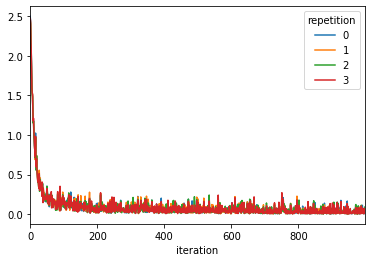

In [13]:
results.pivot(index='iteration', columns='repetition', values='loss').plot()

## Introducing Domain

We have learned to run multiple repetitions of a single experiment with Research. 

We can also run several experiments with different parameters in one research. Suppose we want to compare the performance of:

* VGG7 and VGG16 models with different layouts ('convolution-normalization-activation' vs 'convolution-activation-normalization') and same default bias and pool_strides settings (which are no bias and 2)
* VGG7 with pool_stride 1 and VGG16 with pool_stride 2, both with bias and default 'cna' layout

### Defining Domain

We define a domain of parameters as follows. 
We define an Option that consists of the parameter to vary and a list of values that we want to try in our research. Each parameter value defines a node in a parameter domain. We can add (`+`) domains to unite the nodes, multiply (`*`) them to get Cartesian product and also multiply domain options node-wise (`@`).

`domain.iterator` is a generator that yields one node (that is, a single experiment specification) at a time. Printing a list of all nodes shows us all experiment modifications in a dict-like mode.

In [14]:
domain = (Option('layout', ['cna', 'can']) * Option('model', [VGG7, VGG16]) * Option('bias', [False]) * Option('stride', [2])
        +  Option('layout', ['cna']) * Option('bias', [True]) * (Option('model', [VGG7, VGG16]) @ Option('stride', [1, 2])))
list(domain.iterator)

[ConfigAlias({'layout': 'cna', 'model': 'VGG7', 'bias': 'False', 'stride': '2', 'repetition': '0'}),
 ConfigAlias({'layout': 'cna', 'model': 'VGG16', 'bias': 'False', 'stride': '2', 'repetition': '0'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG7', 'bias': 'False', 'stride': '2', 'repetition': '0'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG16', 'bias': 'False', 'stride': '2', 'repetition': '0'}),
 ConfigAlias({'layout': 'cna', 'bias': 'True', 'model': 'VGG7', 'stride': '1', 'repetition': '0'}),
 ConfigAlias({'layout': 'cna', 'bias': 'True', 'model': 'VGG16', 'stride': '2', 'repetition': '0'})]

Resulting configs have `'repetition'` key to specify the index for repetition for current config. By default there is an one only repetition but it can be specified by `n_reps` parameters of `Domain` (see [tutorial 4](https://github.com/analysiscenter/batchflow/blob/research/examples/tutorials/research/04_advance_usage_of_domain.ipynb))

### Creating Pipelines With Variable Parameters

We should now update `model_config` so that it could read the values from `domain` defined above.

Passing config option named expressions `C()` as parameters values with names from our parameter domain we define layout, pool_strides and bias in the model config. Then, we define model type passing named expression to `init_model` method of the pipeline.

In [15]:
model_config.update({
    'body/block/layout': C('layout'),
    'body/block/pool_strides': C('stride')
})

if MODEL == 'tf':
    model_config['common/conv/use_bias'] = C('bias')
else:
    model_config['common/conv/bias'] = C('bias')

# For reference: previous train_template definition 
#     train_template = (Pipeline()
#                 .init_variable('loss', init_on_each_run=list)
#                 .init_model('dynamic', VGG7, 'conv', config=model_config) # Note model class defined explicitly
#                 .to_array(channels=CHANNELS)
#                 .train_model('conv', 
#                              images=B('images'), targets=B('labels'),
#                              fetches='loss', save_to=V('loss', mode='w'))
#     )

train_template = (Pipeline()
            .init_variable('loss', default=[])
            .init_model('dynamic', C('model'), 'conv', config=model_config) # Model class defined via named expression
            .to_array(channels=CHANNELS)
            .train_model('conv', 
                         images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

### Adding Domain To Research

We define a new research as before but also add the domain of parameters with `init_domain` method. After that we run the research, and it takes much longer because we are now running 6 different experiments 2 times each beacuse we set `n_reps=2`. 

In [16]:
res_name = 'vgg_layout_bias_poolstrides_research'
clear_previous_results(res_name)

research = (Research()
            .init_domain(domain, n_reps=2)
            .add_pipeline(train_ppl, variables='loss', name='train'))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research vgg_layout_bias_poolstrides_research is starting...


Domain updated: 0: 100%|██████████| 12000/12000.0 [13:47<00:00, 14.50it/s]


Research results now contain new columns *layout*, *stride*, *bias* and *model* with corresponding parameter values.

In [17]:
results = research.load_results().df
results.head()

,name,loss,iteration,sample_index,layout,model,bias,stride,repetition,update
0,train,2.367393,0,2698576601,can,VGG7,False,2,1,0
1,train,2.386543,1,2698576601,can,VGG7,False,2,1,0
2,train,2.149122,2,2698576601,can,VGG7,False,2,1,0
3,train,1.822573,3,2698576601,can,VGG7,False,2,1,0
4,train,1.665523,4,2698576601,can,VGG7,False,2,1,0


## Controlling *load_results* Output

### Loading Results With Single-column Config Representation

To combine different config options in a single-column string representation we can pass `concat_config=True` to `load_results` method.

In [18]:
results = research.load_results(concat_config=True).df
results.head()

,name,loss,iteration,sample_index,config,repetition,update
0,train,2.367393,0,2698576601,bias_False-layout_can-model_VGG7-stride_2,1,0
1,train,2.386543,1,2698576601,bias_False-layout_can-model_VGG7-stride_2,1,0
2,train,2.149122,2,2698576601,bias_False-layout_can-model_VGG7-stride_2,1,0
3,train,1.822573,3,2698576601,bias_False-layout_can-model_VGG7-stride_2,1,0
4,train,1.665523,4,2698576601,bias_False-layout_can-model_VGG7-stride_2,1,0


This is very useful when comparing separate experiments.

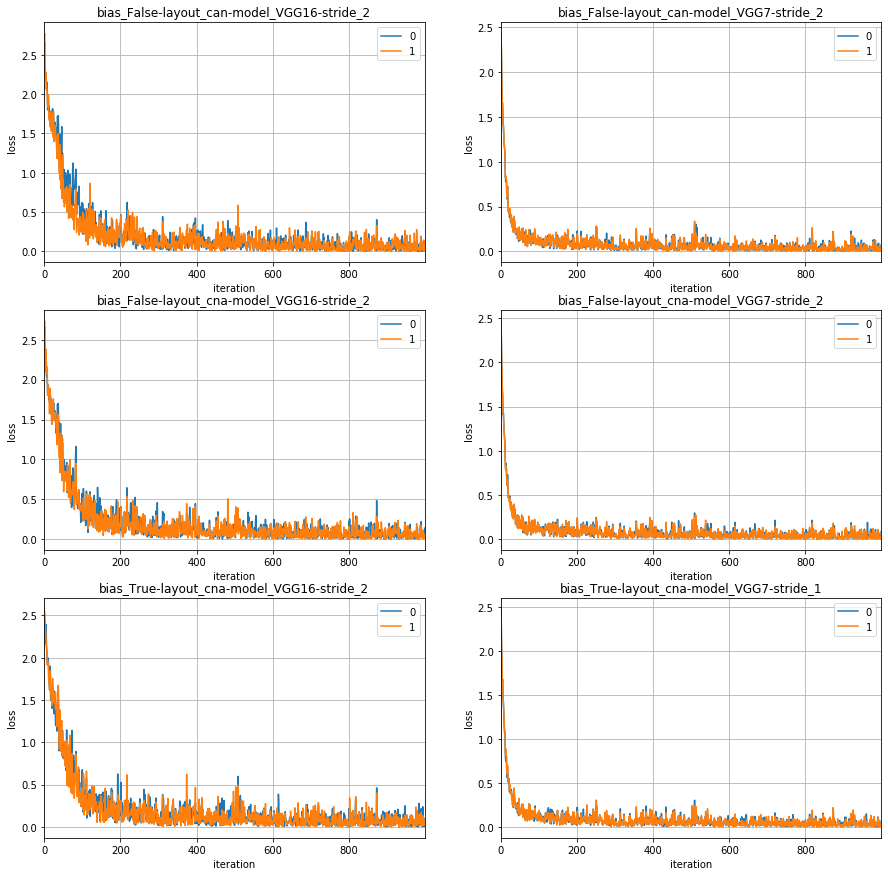

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, (config, df) in enumerate(results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='repetition', values='loss').plot(ax=ax[x, y])
    ax[x, y].set_title(config)
    ax[x, y].set_xlabel('iteration')
    ax[x, y].set_ylabel('loss')
    ax[x, y].grid(True)
    ax[x, y].legend()

### Filtering loaded results

We can filter the results to use certain parameter values.

In [20]:
research.load_results(aliases={'model': 'VGG7'}).df.head()

,name,loss,iteration,sample_index,layout,model,bias,stride,repetition,update
0,train,2.367393,0,2698576601,can,VGG7,False,2,1,0
1,train,2.386543,1,2698576601,can,VGG7,False,2,1,0
2,train,2.149122,2,2698576601,can,VGG7,False,2,1,0
3,train,1.822573,3,2698576601,can,VGG7,False,2,1,0
4,train,1.665523,4,2698576601,can,VGG7,False,2,1,0


The code below does effectively the same but when passing `config` we define actual parameter values (like model class), not their string representations.

In [21]:
research.load_results(configs={'model': VGG7}).df.head()

,name,loss,iteration,sample_index,layout,model,bias,stride,repetition,update
0,train,2.367393,0,2698576601,can,VGG7,False,2,1,0
1,train,2.386543,1,2698576601,can,VGG7,False,2,1,0
2,train,2.149122,2,2698576601,can,VGG7,False,2,1,0
3,train,1.822573,3,2698576601,can,VGG7,False,2,1,0
4,train,1.665523,4,2698576601,can,VGG7,False,2,1,0


We can also get results corresponding to certain repetitions of experiments or certain iterations.

Here we have only one output variable - *loss* - but if we had many we could also load only some of them using `variables` parameter.

In [22]:
research.load_results(repetition=1, iterations=[0,9], variables=['loss']).df.head()

,name,loss,iteration,sample_index,layout,model,bias,stride,repetition,update
0,train,2.367393,0,2698576601,can,VGG7,False,2,1,0
1,train,1.210140,9,2698576601,can,VGG7,False,2,1,0
2,train,2.411114,0,2079493495,cna,VGG7,False,2,1,0
3,train,1.219911,9,2079493495,cna,VGG7,False,2,1,0
4,train,2.558667,0,297606876,cna,VGG16,True,2,1,0


## Loading Saved Research

As mentioned above, after each run of a research a folder with log information and results is created.
Now that 2 researches have run, we can see their resulting folders *vgg7_research* and *vgg_layout_bias_poolstrides_research*.

In [23]:
!ls -la | grep --color -E 'vgg|$'

total 2280
drwxr-xr-x 15 root root    4096 Mar 30 08:35 .
drwxr-xr-x  3 root root    4096 Mar 26 09:41 ..
drwxr-xr-x  2 root root    4096 Mar 27 15:48 .ipynb_checkpoints
-rw-r--r--  1 root root  216219 Mar 30 08:35 01_introduction_to_research.ipynb
-rw-r--r--  1 root root  112305 Mar 27 16:26 02_advanced_usage_of_research.ipynb
-rw-r--r--  1 root root 1870289 Mar 27 15:48 03_plotting_research_results.ipynb
-rw-r--r--  1 root root   21561 Mar 26 09:41 04_advance_usage_of_domain.ipynb
-rw-r--r--  1 root root    8559 Mar 27 15:50 05_update_domain_in_research.ipynb
-rw-r--r--  1 root root   25977 Mar 26 09:41 06_callables.ipynb
-rw-r--r--  1 root root    1387 Mar 26 09:41 README.md
drwxr-xr-x  5 root root    4096 Mar 27 16:12 faster_research
drwxr-xr-x  5 root root    4096 Mar 27 15:53 fn_research
drwxr-xr-x  5 root root    4096 Mar 27 15:56 get_metrics_research
drwxr-xr-x  5 root root    4096 Mar 27 16:03 get_test_loss_research
drwxr-xr-x  2 root root    4096 Mar 26 09:41 img
drwxr-xr-x  

`Research.load` class method is used to load a previousely saved research by its name.

In [24]:
loaded_research = Research.load('vgg_layout_bias_poolstrides_research')

We can check its parameters...

In [25]:
loaded_research.describe()

{'_update_config': None,
 '_update_domain': None,
 'bar': True,
 'branches': 1,
 'devices': [[{'device': None}]],
 'domain': Domain([[Option(layout, ['cna', 'can']), Option(model, ['VGG7', 'VGG16']), Option(bias, ['False']), Option(stride, ['2'])], [Option(layout, ['cna']), Option(bias, ['True']), Option(model, ['VGG7']), Option(stride, ['1'])], [Option(layout, ['cna']), Option(bias, ['True']), Option(model, ['VGG16']), Option(stride, ['2'])]]),
 'executables': OrderedDict([('train',
                              <batchflow.research.executable.Executable object at 0x7feab11f2a90>)]),
 'loaded': True,
 'logger': <batchflow.research.logger.FileLogger object at 0x7feab14c0b00>,
 'n_configs': None,
 'n_iters': 1000,
 'n_reps': 2,
 'n_updates': 0,
 'name': 'vgg_layout_bias_poolstrides_research',
 'repeat_each': 100,
 'timeout': 5,
 'trials': 2,
 'worker_class': <class 'batchflow.research.workers.PipelineWorker'>,
 'workers': 1}


... and run it one more time

In [26]:
res_name = 'vgg_layout_bias_poolstrides_research_loaded'
clear_previous_results(res_name)

loaded_research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Starting loaded research. All parameters passed to run except name, bar and devices are ignored.
 If `devices` is not provided it will be inherited
Research vgg_layout_bias_poolstrides_research_loaded is starting...


Domain updated: 0: 100%|██████████| 12000/12000.0 [13:51<00:00, 14.44it/s]


In [27]:
loaded_research.load_results().df.sample(10)

,name,loss,iteration,sample_index,layout,model,bias,stride,repetition,update
7449,train,0.138700,449,1480049847,cna,VGG16,False,2,1,0
5197,train,0.093987,197,191324610,cna,VGG16,True,2,1,0
1560,train,0.030018,560,3676197507,cna,VGG7,True,1,0,0
3581,train,0.181374,581,2224863699,cna,VGG16,True,2,0,0
7718,train,0.040174,718,1480049847,cna,VGG16,False,2,1,0
3134,train,0.187409,134,2224863699,cna,VGG16,True,2,0,0
951,train,0.062796,951,2302163760,can,VGG7,False,2,1,0
5898,train,0.002500,898,191324610,cna,VGG16,True,2,1,0
835,train,0.016744,835,2302163760,can,VGG7,False,2,1,0
4822,train,0.085941,822,79473344,cna,VGG7,False,2,0,0


## More Complex Execution Strategies

Usually we would like to run more than a single train pipeline.

Let's define a test pipeline to that predicts labels for the test set with the model from the train pipeline on the last iteration of the research. 

### Creating Research with Multiple Pipelines

#### Creating Train Pipeline

We start with defining a train pipeline as before.

In [28]:
domain = Option('layout', ['cna', 'can'])

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array(channels=CHANNELS)
            .train_model('conv', 
                         images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

#### Creating Test Pipeline

We want to run the test pipeline on the whole test set from time to time during training. 

In order to get this, we specify lazy-run in test pipeline with `n_epochs=1` and then pass `run=True` to research's `add_pipeline`. These 2 parameter values tell Research to run the pipeline on the whole test set for 1 epoch, instead of running it batch-wise (which is how the test pipeline is run). We will also pass `execute='last` parameter to `add_pipeline` to tell Research that this pipeline should be executed only on the last iteration.

To let the test pipeline using the model from train pipeline we'll pass it via `C('import_from')`, setting it's value when creating `Research`.

We update the pipeline variable `V('predictions')` with `mode='a'` so that it collects infomation from all batches in `test_ppl`

In [29]:
test_template = (Pipeline()
                 .init_variable('predictions', default=list())
                 .import_model('conv', C('import_from'))
                 .to_array(channels=CHANNELS)
                 .predict_model('conv', 
                                images=B('images'),
                                fetches='predictions', save_to=V('predictions', mode='a'))
                 .run_later(BATCH_SIZE, shuffle=False, n_epochs=1) #Note  n_epochs=1
                )

test_ppl = test_template << mnist.test

#### Creating Research with 2 Pipelines

As mentioned before, we pass `execute='last'` parameter to `add_pipeline` to tell Research that this pipeline should be executed only on the last iteration.

`execute` parameter defines frequency of pipeline execution. One can tell research to execute a pipeline periodically and pass an `int`, or to execute it on specific iteration by passing zero-based iteration number in following format: `'#{it_no}'` or by simply passing `'last'`. `execute` can also be a list, for example, `execute=["#0', '#123', 100, 'last']` means that a pipeline will be executed on first iteration, 124-th iteration, every 100-th iteration and on the last one.

In order to import model from train to test pipeline, we pass `import_from='train_ppl'` parameter to `add_pipeline`, where `'train_ppl'` is the name of our train pipeline.

In [30]:
TEST_EXECUTE_FREQ = 'last'

res_name = 'train_test_research'
clear_previous_results(res_name)

research = (Research()
            .init_domain(domain)
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, variables='predictions', name='test_ppl',
                        execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'))) # Note run=True

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research train_test_research is starting...


Domain updated: 0: 100%|██████████| 2000/2000.0 [02:23<00:00, 13.94it/s]


Now our research results contain entries for `test_ppl`.

In [31]:
research.load_results(names='test_ppl').df.head()

,name,train_loss,predictions,iteration,sample_index,layout,repetition,update
0,test_ppl,NaN,"[[[-2.8400612, -1.9474308, -0.77488196, -3.597...",999,1365345294,can,0,0
1,test_ppl,NaN,"[[[-4.0727715, -2.3626552, -1.1917073, -2.1120...",999,4285264623,cna,0,0


### Functions

In order to perform some computations while running pipelines or to acquire values that are not produced by the model explicitely, one can use functions.

We will now add a function that saves model's snapshots on different stages of learning and reports the path of saved snapshot.

#### Defining Functions To Be Executed By Reasearch

We define a function to be executed during experiment's iterations. Such functions take 2 required parameters: `iteration` and `experiment` which are fed to it by Research and optional keyword parameters which should be provided externally.

Here we declare additional parameters `pipeline` and `model_name` with the names of the model to save and the pipeline is it defined in. We also provide opional path parameter. Firstly, we construct target path using experiment descripton and iteration number. After that we get the pipeline needed by its name. Finally, we save the model with the name from parameters in this pipeline. Our function will return target path, so that one could easyly find the saved model.

In [32]:
def save_model(pipeline, model_name, path):
    """ Save model to a path."""
    pipeline.save_model_now(model_name, path)
    return path

#### Adding Functions To Research

We define a new reseach. 

To add a function we call `add_callable` method, providing it with a function object and `returns` parameters that specifies what should be written to research results.  We also pass keyword parameters `pipeline='train_ppl'`, `model_name='conv'`, `path='my_mdl'` that will be substituted to `save_model` function.

In [37]:
res_name = 'fn_research'
clear_previous_results(res_name)

research = (Research()
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_callable(save_model, returns='snapshot_path', name='save_model_fn',
                          execute=TEST_EXECUTE_FREQ, pipeline=RP('train_ppl'), model_name='conv', path=L(lambda p: os.path.join(p, 'saved_model'))(REP()))
            .init_domain(domain, n_reps=1))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research fn_research is starting...


Domain updated: 0: 100%|██████████| 2000/2000.0 [02:13<00:00, 14.97it/s]


Research results now contain paths to models snapshots from `'save_model_fn'`

We can load results that come from a certain source by passing `names` parameter to `load_results`

In [38]:
research.load_results(names='save_model_fn').df.head()

,name,train_loss,snapshot_path,iteration,sample_index,layout,repetition,update
0,save_model_fn,NaN,fn_research/results/layout_can-repetition_0-up...,999,309941219,can,0,0
1,save_model_fn,NaN,fn_research/results/layout_cna-repetition_0-up...,999,2025661558,cna,0,0


We can inspect current folder contents and see, that `fn_research` directory was created.

In [35]:
!ls -la | grep --color -E 'fn_research|$'

total 2292
drwxr-xr-x 10 root root    4096 Mar 27 15:54 .
drwxr-xr-x  3 root root    4096 Mar 26 09:41 ..
drwxr-xr-x  2 root root    4096 Mar 27 15:48 .ipynb_checkpoints
-rw-r--r--  1 root root  248944 Mar 27 15:54 01_introduction_to_research.ipynb
-rw-r--r--  1 root root  112305 Mar 27 15:47 02_advanced_usage_of_research.ipynb
-rw-r--r--  1 root root 1870289 Mar 27 15:48 03_plotting_research_results.ipynb
-rw-r--r--  1 root root   21561 Mar 26 09:41 04_advance_usage_of_domain.ipynb
-rw-r--r--  1 root root    8559 Mar 27 15:50 05_update_domain_in_research.ipynb
-rw-r--r--  1 root root   25977 Mar 26 09:41 06_callables.ipynb
-rw-r--r--  1 root root    1387 Mar 26 09:41 README.md
drwxr-xr-x  5 root root    4096 Mar 27 15:53 fn_research
drwxr-xr-x  5 root root    4096 Mar 27 14:20 get_metrics_research
drwxr-xr-x  2 root root    4096 Mar 26 09:41 img
drwxr-xr-x  5 root root    4096 Mar 27 15:51 train_test_research
drwxr-xr-x  5 root root    4096 Mar 27 15:19 vgg7_research
drwxr-xr-x  5 roo

It contains subdirectories with models snapshots

In [40]:
!tree fn_research/results

fn_research/results
├── layout_can-repetition_0-update_0
│   └── 309941219
│       ├── save_model_fn_1000
│       ├── saved_model
│       └── train_ppl_1000
└── layout_cna-repetition_0-update_0
    └── 2025661558
        ├── save_model_fn_1000
        ├── saved_model
        └── train_ppl_1000

4 directories, 6 files


### Getting metrics

There is a special research method `get_metrics` for collecting metrics.

#### Defining Test Pipeline That Gathers Metrics

First we redefine the test pipeline and add variables to store predictions and metrics computed for these predictions via `gather_metrics`.

We update `V('predictions')` with default mode `mode='w'`, that is overwrite it on each `test_ppl` iteration, because we need it only to compute metrics. We update `V('metrics')` with `mode='a'` because we want it to keep metrics from all batches in `test_ppl`.

In [41]:
TEST_EXECUTE_FREQ = [100, 'last']

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array(channels=CHANNELS)
                 .predict_model('conv', 
                                images=B('images'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics', mode='a'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))

test_ppl = test_template << mnist.test

#### Collecting Metrics in Research

We pass test pipeline name to collect metrics from it (`pipeline='test_ppl'`), named expression storing collected metrics (`metrics_var='metrics'`) and string indicating which metric to calculate (`metrics_name='accuracy'`). We also can add `PrintLogger` as logger and all messages will be streamed into `stdout`.

In [42]:
res_name = 'get_metrics_research'
clear_previous_results(res_name)

research = (Research()
            .add_logger('print')
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'))
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=TEST_EXECUTE_FREQ)
            .init_domain(domain))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research get_metrics_research is starting...
Distributor [id:34642] is preparing workers
Create queue of jobs
Run 1 worker


0it [00:00, ?it/s]

Start Worker 0 [id:26488] (devices: [None])


Domain updated: 0: : 0it [00:00, ?it/s]

Worker 0 is creating process for Job 0
Job 0 was started in subprocess [id:26496] by Worker 0
Job 0 has the following configs:
{'layout': 'cna', 'update': '0', 'repetition': '0'}


Domain updated: 0:  50%|████▉     | 999/2000.0 [01:46<01:46,  9.42it/s] 

Job 0 [26496] was finished by Worker 0


Domain updated: 0:  50%|█████     | 1000/2000.0 [01:46<01:46,  9.42it/s]

Worker 0 is creating process for Job 1
Job 1 was started in subprocess [id:29523] by Worker 0
Job 1 has the following configs:
{'layout': 'can', 'update': '0', 'repetition': '0'}


Domain updated: 0: 100%|█████████▉| 1999/2000.0 [03:25<00:00,  9.71it/s]

Job 1 [29523] was finished by Worker 0


Domain updated: 0: 100%|██████████| 2000/2000.0 [03:25<00:00,  9.72it/s]


All workers have finished the work


`get_metrics` implicitly adds a function with a name *\[pipeline_name\]_\[metrics_var\]*.

In [43]:
research.load_results(names='test_ppl_metrics').df.sample(5)

,name,train_loss,accuracy,iteration,sample_index,layout,repetition,update
11,test_ppl_metrics,NaN,0.929837,199,995518809,cna,0,0
17,test_ppl_metrics,NaN,0.984972,799,995518809,cna,0,0
3,test_ppl_metrics,NaN,0.975518,399,1147537159,can,0,0
1,test_ppl_metrics,NaN,0.953424,199,1147537159,can,0,0
16,test_ppl_metrics,NaN,0.988455,699,995518809,cna,0,0


### Getting Test Loss

#### Defining Test Pipeline That Calculates Tets Loss

In order to monitor test loss one can use `Metrics` machinery. 
We add `gather_metrics` of type `'loss'` and pass current loss and batch size

In [44]:
test_template = (Pipeline()
                .init_variable('loss')
                .init_variable('predictions')
                .init_variable('test_loss')
                .init_variable('metric_class')
                .import_model('conv', C('import_from'))
                .to_array(channels=CHANNELS)
                .predict_model('conv', 
                               images=B.images, labels=B.labels,
                               fetches=['loss', 'predictions'],
                               save_to=[V('loss'), V('predictions')])
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metric_class', mode='a'))
                .gather_metrics('loss', loss=V('loss'), batch_len=B.images.shape[0], save_to=V('test_loss', mode='a'))
                .run_later(BATCH_SIZE, n_epochs=1, shuffle=False)
)

test_ppl = test_template << mnist.test

#### Collecting Test Loss In Research

We collect test loss in research as before

In [45]:
res_name='get_test_loss_research'
clear_previous_results(res_name)

research = (Research()
    .init_domain(domain)
    .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
    .add_pipeline(test_ppl, name='test_ppl',
                  execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'), drop_last=True)
    .get_metrics(pipeline='test_ppl', metrics_var='test_loss', metrics_name='loss',
                 returns='test_loss', execute=TEST_EXECUTE_FREQ)
    .get_metrics(pipeline='test_ppl', metrics_var='metric_class', metrics_name='accuracy',
                 returns='accuracy', execute=TEST_EXECUTE_FREQ)
    
)

research.run(n_iters=ITERATIONS, name=res_name, bar=True)


Research get_test_loss_research is starting...


Domain updated: 0: 100%|██████████| 2000/2000.0 [03:30<00:00,  9.48it/s]


In [46]:
df = research.load_results(concat_config=True).df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 9 columns):
name            2040 non-null object
train_loss      2000 non-null float64
test_loss       20 non-null float64
accuracy        20 non-null float64
iteration       2040 non-null int64
sample_index    2040 non-null object
config          2040 non-null object
repetition      2040 non-null int64
update          2040 non-null int64
dtypes: float64(3), int64(3), object(3)
memory usage: 143.6+ KB


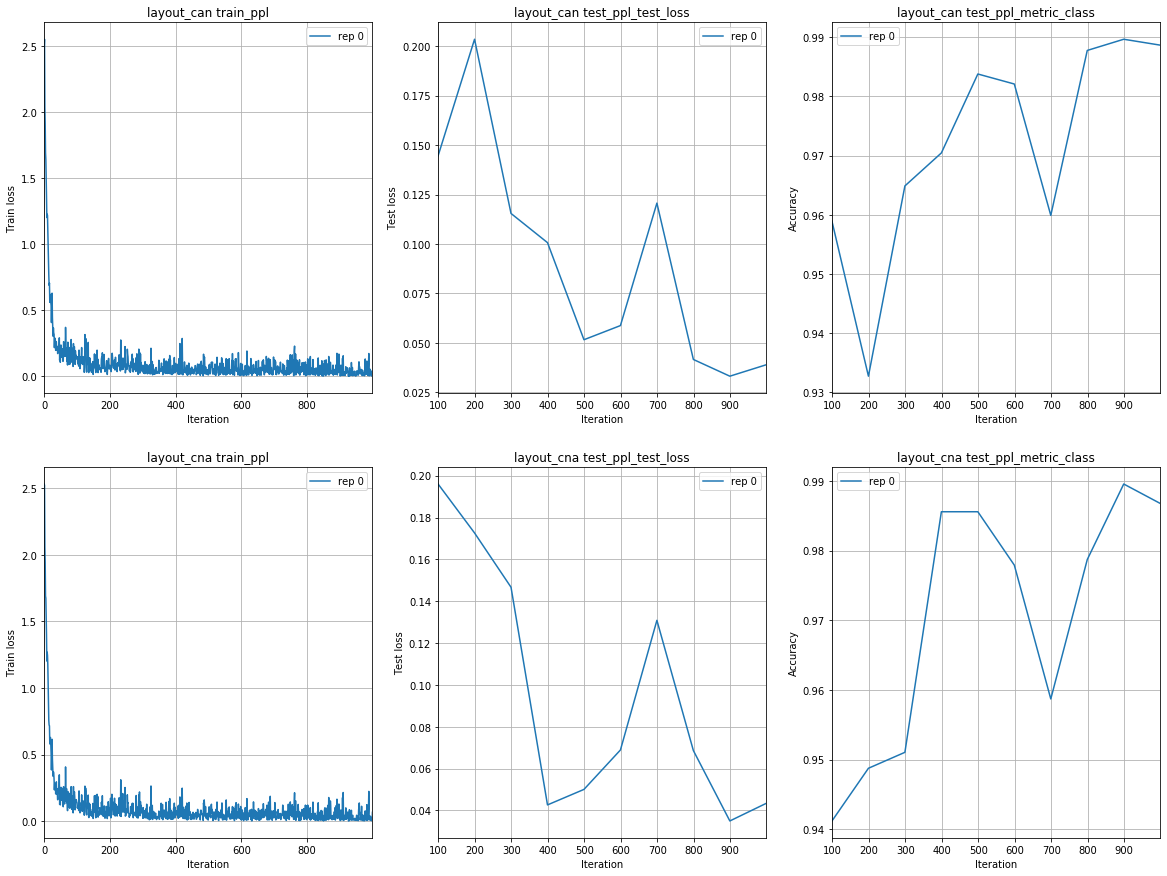

In [47]:
from batchflow.utils import plot_results_by_config

plot_results_by_config(df, {'train_ppl': 'train_loss', 
                            'test_ppl_test_loss': 'test_loss', 
                            'test_ppl_metric_class': 'accuracy'},
                       figsize=(20, 15))